In [1]:
import random

import torch
import torch.nn as nn
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.autograd as autograd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

manualSeed = random.randint(1, 10000)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

print("Seed:", manualSeed)

Seed: 2722


In [2]:
# Edit to View and Create More Images

batch_size = 128
img_shape = (3, 64, 64)

# Size of Generator Input

nz = 100

# Size of Feature Maps

featureSize = 64

# Create the Datasets

transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

dataset_mountains = dset.ImageFolder(root="../data/mountains", transform=transform)
dataset_two = dset.ImageFolder(root="../data/mountains", transform=transform)
dataset_three = dset.ImageFolder(root="../data/mountains", transform=transform)

dataloader_mountains = torch.utils.data.DataLoader(dataset_mountains, batch_size=batch_size, shuffle=True, num_workers=2)
dataloader_two = torch.utils.data.DataLoader(dataset_two, batch_size=batch_size, shuffle=True, num_workers=2)
dataloader_three = torch.utils.data.DataLoader(dataset_three, batch_size=batch_size, shuffle=True, num_workers=2)

# Set To Zero For CPU Mode

ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu == 1) else "cpu")
    
print("Running On Device:", device)

Running On Device: cuda:0


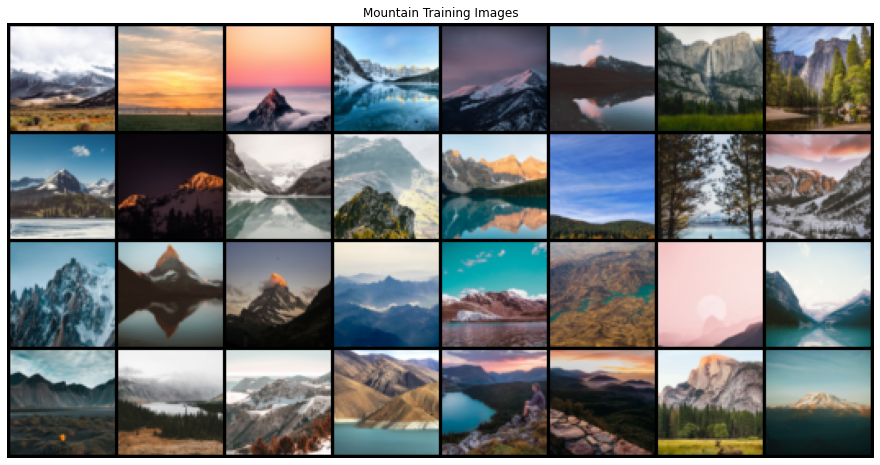

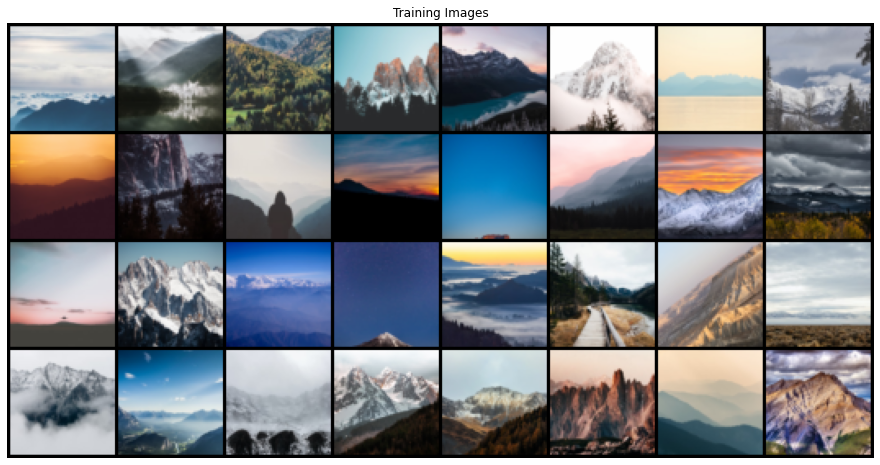

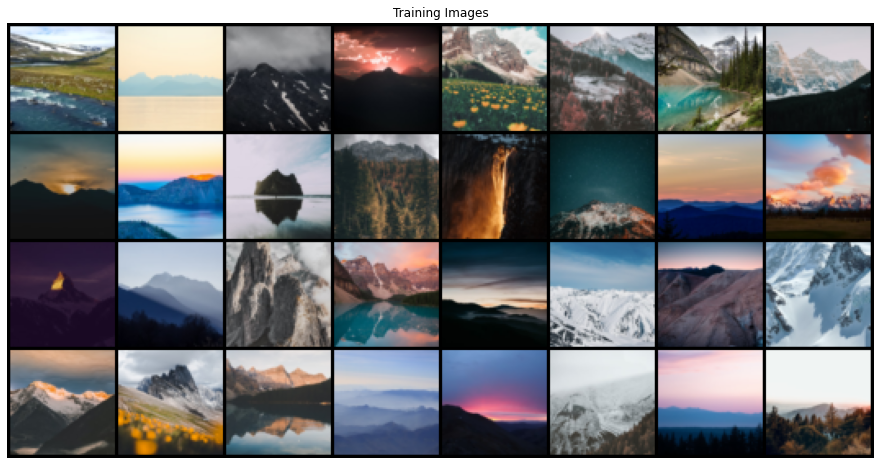

In [3]:
# Show Some Training Images

real_batch = next(iter(dataloader_mountains))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Mountain Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)));

real_batch = next(iter(dataloader_two))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)));

real_batch = next(iter(dataloader_three))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)));

In [4]:
def show_results(dataloader, img_list):
    
    # Grab a batch of real images from the dataloader
    real_batch = next(iter(dataloader))

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.show()

In [5]:
def do_run(dataloader, epochs):

    netG = Generator(ngpu).to(device)
    netG.apply(weights_init)

    netD = Discriminator(ngpu).to(device)
    netD.apply(weights_init)

    # print(netG, netD)
    
    img_list = main_loop(dataloader, netG, netD, epochs)
    
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

    HTML(ani.to_jshtml())

    show_results(dataloader, img_list)

## Traditional GAN

To begin with, we attempt to run a traditional GAN on the three datasets.

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
class Generator(nn.Module):
    
    def __init__(self, ngpu):
        
        super(Generator, self).__init__()
        
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, featureSize * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(featureSize * 8),
            nn.ReLU(True),
            # state size. (featureSize * 8) x 4 x 4
            nn.ConvTranspose2d(featureSize * 8, featureSize * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(featureSize * 4),
            nn.ReLU(True),
            # state size. (featureSize * 4) x 8 x 8
            nn.ConvTranspose2d(featureSize * 4, featureSize * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(featureSize * 2),
            nn.ReLU(True),
            # state size. (featureSize * 2) x 16 x 16
            nn.ConvTranspose2d(featureSize * 2, featureSize, 4, 2, 1, bias=False),
            nn.BatchNorm2d(featureSize),
            nn.ReLU(True),
            # state size. (featureSize) x 32 x 32
            nn.ConvTranspose2d(featureSize, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (3) x 64 x 64
        )

    def forward(self, input):
        
        return self.main(input)

In [8]:
class Discriminator(nn.Module):
    
    def __init__(self, ngpu):
        
        super(Discriminator, self).__init__()
        
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (3) x 64 x 64
            nn.Conv2d(3, featureSize, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (featureSize) x 32 x 32
            nn.Conv2d(featureSize, featureSize * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(featureSize * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (featureSize * 2) x 16 x 16
            nn.Conv2d(featureSize * 2, featureSize * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(featureSize * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (featureSize * 4) x 8 x 8
            nn.Conv2d(featureSize * 4, featureSize * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(featureSize * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (featureSize * 8) x 4 x 4
            nn.Conv2d(featureSize * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        
        return self.main(input)

In [9]:
def main_loop(dataloader, netD, netG, epochs):
    
    criterion = nn.BCELoss()
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)

    real_label = 1
    fake_label = 0

    optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Training Loop

    img_list = []
    iters = 0

    for epoch in range(epochs):
                
        for i, data in enumerate(dataloader, 0):

            ############################
            # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            
            # Train D on Real Images
            
            netD.zero_grad()
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, device=device)
            output = netD(real_cpu).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()

            # Generate Fake Images
            
            fake = netG(torch.randn(b_size, nz, 1, 1, device=device))
            label.fill_(fake_label)

            # Train D on Fake Images
            
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            errD = errD_real + errD_fake
            optimizerD.step()

            ############################
            # Update G network: maximize log(D(G(z)))
            ###########################
            
            netG.zero_grad()
            label.fill_(real_label)
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            optimizerG.step()

            if epoch % 10 == 0:
                
                print('[Epoch %d/%d] [Loss_D: %.4f] [Loss_G: %.4f]' % (epoch, epochs, errD.item(), errG.item()))

            if (iters % 500 == 0) or ((epoch == epochs - 1) and (i == len(dataloader) - 1)):
                
                with torch.no_grad():
                    
                    fake = netG(fixed_noise).detach().cpu()
                
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1
            
    return img_list

In [10]:
do_run(dataloader_mountains, 50)

..\aten\src\ATen\native\TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


RuntimeError: Given transposed=1, weight of size [100, 512, 4, 4], expected input[128, 3, 64, 64] to have 100 channels, but got 3 channels instead

In [ ]:
do_run(dataloader_two, 50)

In [ ]:
do_run(dataloader_three, 50)

## Wasserstein GAN

The Wasserstein GAN [(paper here)](https://arxiv.org/abs/1701.07875) is a improve GAN model that improves learning 
stability and helps get rid of problems like mode collapse, which we experienced with our first GAN model.

In [ ]:
class Generator(nn.Module):
    
    def __init__(self, ngpu):
        
        super(Generator, self).__init__()

        self.ngpu = ngpu
        
        def block(in_feat, out_feat, normalize=True):
            
            layers = [nn.Linear(in_feat, out_feat)]
            
            if normalize:
                
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self, ngpu):
        
        super(Discriminator, self).__init__()
        
        self.ngpu = ngpu
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [ ]:
def compute_gradient_penalty(D, real_samples, fake_samples):

    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

In [ ]:
def main_loop(dataloader, netD, netG, epochs):

    Tensor = torch.cuda.FloatTensor if device.type == 'cuda' else torch.FloatTensor

    img_list = []
    batches_done = 0
    fixed_noise = Variable(Tensor(np.random.normal(0, 1, (img_shape[0], 100))))
    iters = 0

    optimizer_G = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(epochs):
    
        for i, (imgs, _) in enumerate(dataloader):

            # Configure input
            real_imgs = Variable(imgs.type(Tensor))

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Sample noise as generator input
            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

            # Generate a batch of images
            fake_imgs = netG(z)

            # Real images
            real_validity = netD(real_imgs)
            # Fake images
            fake_validity = netD(fake_imgs)
            # Gradient penalty
            gradient_penalty = compute_gradient_penalty(netD, real_imgs.data, fake_imgs.data)
            # Adversarial loss
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + 10 * gradient_penalty

            d_loss.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()

            # Train the generator every n_critic steps
            if i % 5 == 0:

                # -----------------
                #  Train Generator
                # -----------------

                # Generate a batch of images
                fake_imgs = netG(z)
                # Loss measures generator's ability to fool the discriminator
                # Train on fake images
                fake_validity = netD(fake_imgs)
                g_loss = -torch.mean(fake_validity)

                g_loss.backward()
                optimizer_G.step()

                print("[Epoch %d/%d] [Loss_D: %.4f] [Loss_G: %.4f]" % (epoch, epochs, d_loss.item(), g_loss.item()))

                batches_done += 5
            
                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 500 == 0) or ((epoch == epochs - 1) and (i == len(dataloader) - 1)):
                    
                    with torch.no_grad():

                        fake = netG(fixed_noise).detach().cpu()
                
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
                
                iters += 1

In [ ]:
do_run(dataloader_mountains, 50)

In [ ]:
do_run(dataloader_two, 50)

In [ ]:
do_run(dataloader_three, 50)